## Load and Summary

In [1]:
# read rds file
import pyreadr

rds_path1 = "/projects/wangc/m344313/OVTMA_project/data/bms1/bms1_part1.rds"

# read rds file
r1 = pyreadr.read_r(rds_path1)

# read rds file
rds_path2 = "/projects/wangc/m344313/OVTMA_project/data/bms1/bms1_part2.rds"

# read rds file
r2 = pyreadr.read_r(rds_path2)


In [ ]:
import pandas as pd
# get the 1st item of the iterator
df1 = next(iter(r1.items()))[1]
df2 = next(iter(r2.items()))[1]
raw_df = pd.concat([df1, df2])
# convert index to cell_id column
raw_df.index.name = "cell_id"
raw_df.reset_index(inplace=True)
print(raw_df.shape)
print(raw_df.head())


(3649983, 8)
   cell_id patientID    imageID  responder        fov        x       y  \
0        0     Mel30  Mel30_001          0  interface   982.39  1186.2   
1        1     Mel30  Mel30_001          0  interface  1377.90  1183.1   
2        2     Mel30  Mel30_001          0  interface  1656.50  1177.9   
3        3     Mel30  Mel30_001          0  interface    72.73  1175.6   
4        4     Mel30  Mel30_001          0  interface   345.14  1179.3   

          cell_type  
0  Cytotoxic T Cell  
1            B Cell  
2            B Cell  
3    Dendritic Cell  
4        Tumor Cell  


In [ ]:
# raw_df.to_csv('/projects/wangc/m344313/OVTMA_project/data/bms1/full_df.csv',index=False)
# raw_df[raw_df['fov'] == 'stroma'].to_csv('/projects/wangc/m344313/OVTMA_project/data/bms1/stroma_df.csv',index=False)
# raw_df[raw_df['fov'] == 'tumor'].to_csv('/projects/wangc/m344313/OVTMA_project/data/bms1/tumor_df.csv',index=False)
# raw_df[raw_df['fov'] == 'interface'].to_csv('/projects/wangc/m344313/OVTMA_project/data/bms1/interface_df.csv',index=False)


In [4]:
print(raw_df['patientID'].value_counts())
print(raw_df['imageID'].value_counts())
print(raw_df['fov'].value_counts())
print(raw_df['cell_type'].value_counts())

print(raw_df.groupby('responder')['patientID'].nunique())
print(raw_df.groupby('patientID')['imageID'].nunique())
print(raw_df.groupby('fov')['imageID'].nunique())

print(f'{len(raw_df["patientID"].unique())} patients, {len(raw_df["imageID"].unique())} images, {len(raw_df["cell_type"].unique())} cell types')
print(f'{raw_df.groupby("responder")["patientID"].nunique()}')

patientID
Mel55    320393
Mel49    231512
Mel51    207333
Mel36    200436
Mel38    193418
Mel46    192644
Mel54    189730
Mel52    185464
Mel30    181360
Mel40    176897
Mel44    175334
Mel41    168616
Mel45    159185
Mel48    153318
Mel43    153154
Mel50    146671
Mel35    137126
Mel47    115691
Mel53     94207
Mel42     89335
Mel39     79937
Mel56     70964
Mel68     27258
Name: count, dtype: int64
imageID
Mel30_029    10794
Mel30_028    10743
Mel46_030    10471
Mel51_031    10448
Mel38_015    10302
             ...  
Mel53_022     1752
Mel35_012     1737
Mel35_029     1728
Mel50_018     1593
Mel47_012     1451
Name: count, Length: 711, dtype: int64
fov
stroma       1629500
interface    1148907
tumor         871576
Name: count, dtype: int64
cell_type
Tumor Cell             1024164
B Cell                  781536
Helper T Cell           520667
Macrophage              365535
Cytotoxic T Cell        350879
Stromal Cell            203268
Dendritic Cell          137190
Regulatory T Cell   

## intact vs mixed

### Moran's I (tumor vs non-tumor)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from libpysal.weights import KNN, DistanceBand, WSP
from esda.moran import Moran
from esda.join_counts import Join_Counts
import statsmodels.formula.api as smf

# assume df has columns: patientID, imageID, responder, fov, x, y, cell_type
df = raw_df.copy()
#df = df[df['fov'] == 'interface']
df["cell_type"] = np.where(df["cell_type"].values == "Tumor Cell", "Tumor", "Non Tumor")
df["tumor_bin"] = (df["cell_type"] == "Tumor").astype(float)



In [ ]:

def moran_for_group(coords: np.ndarray, values: np.ndarray, method="knn", k=10, radius=None,jc = False):
    """
    Compute Moran's I given coordinates (N x 2) and values (N,).
    method: 'knn' or 'radius'
    - knn: uses KNN.from_array 
    - radius: uses DistanceBand.from_array (neighbors within radius)
    Returns: float Moran's I
    """
    if coords.shape[0] < 3:
        return np.nan
    if method == "knn":
        w = KNN.from_array(coords, k=k)
    elif method == "radius":
        if radius is None:
            raise ValueError("Provide 'radius' (same units as x/y) for method='radius'")
        
        w = DistanceBand.from_array(coords, threshold=radius, binary=True, silence_warnings=True)
        # Guard for isolated points: if everyone is isolated, Moran is undefined
        if w.n_components > 1 and w.s0 == 0:
            return np.nan
    else:
        raise ValueError("method must be 'knn' or 'radius'")
    mi = Moran(values, w)
    if jc:
        jc = Join_Counts(values, w)
        return float(mi.I), float(jc.bw)
    else:
        return float(mi.I)

results = []
#(A) fast KNN or (B) fixed-radius
USE_METHOD = "radius"    # or "radius"
K = 10                
RADIUS = 50         

for img, g in df.groupby("imageID", sort=False):
    coords = g[["x","y"]].to_numpy()
    vals = g["tumor_bin"].to_numpy(dtype=float)
    I = moran_for_group(coords, vals, method=USE_METHOD, k=K, radius=RADIUS)
    results.append({"imageID": img,
                    "moran_I": I,
                    "responder": g["responder"].iloc[0]})

result_df = pd.DataFrame(results).dropna(subset=["moran_I"]).reset_index(drop=True)
print(result_df.head())
result_df.to_csv('./bms1_moran_df.csv',index=False)



In [9]:
print(df.head())

   cell_id patientID    imageID  responder        fov        x       y  \
0        0     Mel30  Mel30_001          0  interface   982.39  1186.2   
1        1     Mel30  Mel30_001          0  interface  1377.90  1183.1   
2        2     Mel30  Mel30_001          0  interface  1656.50  1177.9   
3        3     Mel30  Mel30_001          0  interface    72.73  1175.6   
4        4     Mel30  Mel30_001          0  interface   345.14  1179.3   

   cell_type  tumor_bin  
0  Non Tumor        0.0  
1  Non Tumor        0.0  
2  Non Tumor        0.0  
3  Non Tumor        0.0  
4      Tumor        1.0  


## Adjust Moran's I to include tumor/non-tumor dominance

In [44]:
''' adjusted score '''
result_df = pd.read_csv('./bms1_moran_df.csv')
print(result_df.head())
adj_df = result_df.copy()
# first gate to 0~1
adj_df["moran_I"] = adj_df["moran_I"].apply(lambda x: 0 if x < 0 else 1 if x > 1 else x)
#adj_df["moran_I"] = adj_df["moran_I"].apply(lambda x: 1-x)
# then for Tumor-dominant, add sign -

# --- compute tumor-dominance per imageID from *raw_df* ---
_tmp = raw_df.dropna(subset=["imageID", "cell_type"]).copy()
_tmp["tumor_bin"] = (_tmp["cell_type"].values == "Tumor Cell").astype(float)

tumor_frac = _tmp.groupby("imageID")["tumor_bin"].mean()
tumor_dom_map = tumor_frac.gt(0.5)

# --- apply sign flip to the clamped values in adj_df ---
adj_df["is_tumor_dominant"] = adj_df["imageID"].map(tumor_dom_map)
# flip sign only where True (images missing from the map are left unchanged)
mask = adj_df["is_tumor_dominant"].fillna(False)
adj_df.loc[mask, "moran_I"] = -adj_df.loc[mask, "moran_I"]

print(adj_df.head())

adj_df.to_csv("./bms1_moran_df_signed.csv", index=False)






     imageID   moran_I  responder
0  Mel30_001  0.397520          0
1  Mel30_002  0.399027          0
2  Mel30_003  0.398399          0
3  Mel30_004  0.507824          0
4  Mel30_005  0.344041          0
     imageID   moran_I  responder  is_tumor_dominant
0  Mel30_001  0.397520          0              False
1  Mel30_002  0.399027          0              False
2  Mel30_003  0.398399          0              False
3  Mel30_004  0.507824          0              False
4  Mel30_005  0.344041          0              False


### Prepare for plotting HE overlay

In [32]:
# for patientID == 'Mel43' or 'Mel44', get the fov value for each unique imageID

subset = raw_df[raw_df["patientID"].isin(["Mel43", "Mel44"])]
result = (
    subset.groupby("imageID")["fov"].unique()
    .explode()               # turn each list into multiple rows
    .reset_index()
)
print(result.head())
print(result.shape)
moran_df = pd.read_csv('./bms1_moran_df.csv')
result = result.merge(moran_df[['imageID','moran_I']], on='imageID', how='left')
print(result.head())
print(result.shape)

result.rename(columns={'imageID':'Sample','fov':'Pathology'}, inplace=True)
result['Slide'] = result['Sample'].str.split('_', expand=True)[0]+'_BMS'

result['Sample'] = result['Slide']+'_region_'+result['Sample'].str.split('_', expand=True)[1]
print(result.head())
result.to_csv('../plot_overlay/labels.csv',index=False)


     imageID        fov
0  Mel43_001  interface
1  Mel43_002  interface
2  Mel43_003  interface
3  Mel43_004  interface
4  Mel43_005  interface
(71, 2)
     imageID        fov   moran_I
0  Mel43_001  interface  0.732435
1  Mel43_002  interface  0.604376
2  Mel43_003  interface  0.365702
3  Mel43_004  interface  0.362631
4  Mel43_005  interface  0.448538
(71, 3)
                 Sample  Pathology   moran_I      Slide
0  Mel43_BMS_region_001  interface  0.732435  Mel43_BMS
1  Mel43_BMS_region_002  interface  0.604376  Mel43_BMS
2  Mel43_BMS_region_003  interface  0.365702  Mel43_BMS
3  Mel43_BMS_region_004  interface  0.362631  Mel43_BMS
4  Mel43_BMS_region_005  interface  0.448538  Mel43_BMS


In [ ]:
# for patientID == 'Mel43' or 'Mel44', get the fov value for each unique imageID

subset = raw_df[raw_df["patientID"].isin(["Mel43", "Mel44"])]
result = (
    subset.groupby("imageID")["fov"].unique()
    .explode()               # turn each list into multiple rows
    .reset_index()
)
print(result.head())
print(result.shape)
moran_df = pd.read_csv('./bms1_moran_df_signed.csv')
result = result.merge(moran_df[['imageID','moran_I']], on='imageID', how='left')
print(result.head())
print(result.shape)

result.rename(columns={'imageID':'Sample','fov':'Pathology'}, inplace=True)
result['Slide'] = result['Sample'].str.split('_', expand=True)[0]+'_BMS'

result['Sample'] = result['Slide']+'_region_'+result['Sample'].str.split('_', expand=True)[1]
print(result.head())
result.to_csv('../plot_overlay/labels_signed.csv',index=False)

python drawFOV_cli.py \
--base "/people/m344313/Map_FOV_Back_On_vHnE" \
--outdir "/people/m344313/Map_FOV_Back_On_vHnE/overlays/moran_I_signed" \
--labels "./labels_signed.csv" \
--targets Mel43_BMS Mel44_BMS \
--moves-file "MOVES.xml" \
--vhe-pattern "S001_VHE_region_001.tif" \
--static-size 1210 1140 \
--downscale 0.10 \
--font-path "./arial.ttf" \
--font-size 320 \
--cont-col moran_I \
--vmin -1 \
--vmax 1 \
--alpha-fill 200 



     imageID        fov
0  Mel43_001  interface
1  Mel43_002  interface
2  Mel43_003  interface
3  Mel43_004  interface
4  Mel43_005  interface
(71, 2)
     imageID        fov   moran_I
0  Mel43_001  interface  0.267565
1  Mel43_002  interface  0.395624
2  Mel43_003  interface  0.634298
3  Mel43_004  interface  0.637369
4  Mel43_005  interface  0.551462
(71, 3)
                 Sample  Pathology   moran_I      Slide
0  Mel43_BMS_region_001  interface  0.267565  Mel43_BMS
1  Mel43_BMS_region_002  interface  0.395624  Mel43_BMS
2  Mel43_BMS_region_003  interface  0.634298  Mel43_BMS
3  Mel43_BMS_region_004  interface  0.637369  Mel43_BMS
4  Mel43_BMS_region_005  interface  0.551462  Mel43_BMS


### Plot ranked ROI

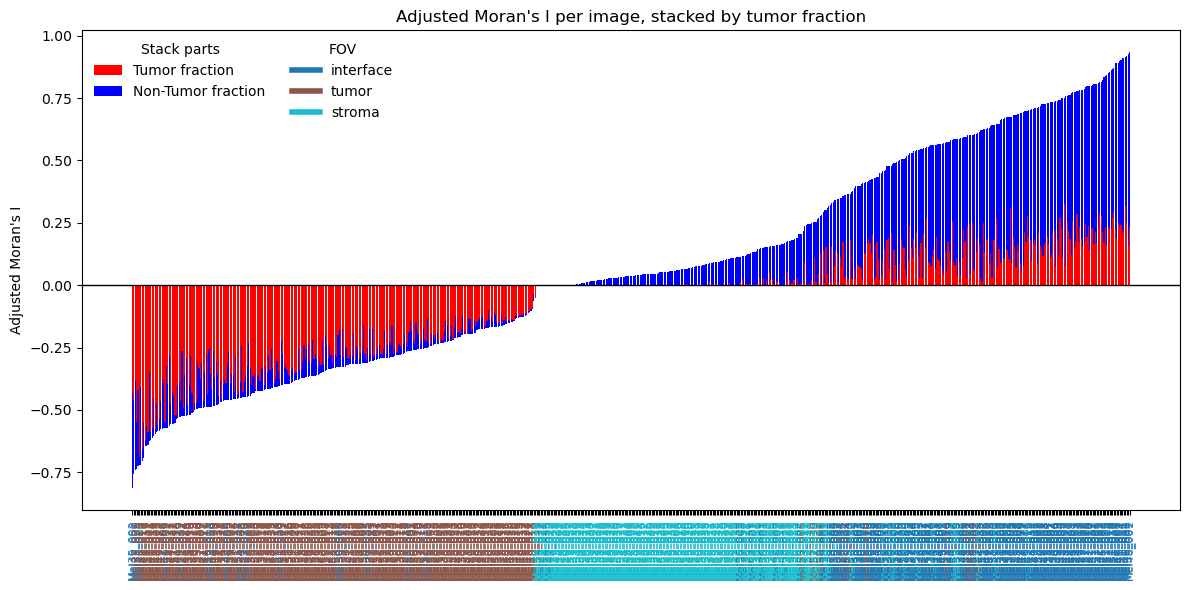

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- build tumor_frac and fov maps ---
_tmp = raw_df.dropna(subset=["imageID", "cell_type", "fov"]).copy()
_tmp["tumor_bin"] = (_tmp["cell_type"].values == "Tumor Cell").astype(float)

tumor_frac = _tmp.groupby("imageID")["tumor_bin"].mean()
fov_map    = _tmp.groupby("imageID")["fov"].first()

# attach to adj_df
plot_df = adj_df.copy()
plot_df["tumor_frac"] = plot_df["imageID"].map(tumor_frac)
plot_df["fov"]        = plot_df["imageID"].map(fov_map)

# clean and sort
plot_df = plot_df.dropna(subset=["moran_I", "tumor_frac", "fov"]).reset_index(drop=True)
plot_df = plot_df.sort_values("moran_I", ascending=True).reset_index(drop=True)

# compute stacked heights
h_tumor = plot_df["moran_I"] * plot_df["tumor_frac"]
h_rest  = plot_df["moran_I"] * (1.0 - plot_df["tumor_frac"])
x = np.arange(len(plot_df))

# --- plot stacked bars ---
# --- plot stacked bars ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, h_tumor, color="red", label="Tumor fraction")
ax.bar(x, h_rest, bottom=h_tumor, color="blue", label="Non-Tumor fraction")
ax.axhline(0, linewidth=1, color="k")

# --- color x-axis ticks by fov ---
unique_fovs = plot_df["fov"].unique()
cmap = plt.get_cmap("tab10", len(unique_fovs))
fov_to_color = {f: cmap(i) for i, f in enumerate(unique_fovs)}

xticks = x
xticklabels = plot_df["imageID"].astype(str).tolist()
colors = [fov_to_color[f] for f in plot_df["fov"]]

ax.set_xticks(xticks, xticklabels)
for tick_label, color in zip(ax.get_xticklabels(), colors):
    tick_label.set_rotation(90)
    tick_label.set_fontsize(8)
    tick_label.set_color(color)

ax.set_ylabel("Adjusted Moran's I")
ax.set_title("Adjusted Moran's I per image, stacked by tumor fraction")
fig.tight_layout()



handles1, labels1 = ax.get_legend_handles_labels()

fov_handles = [plt.Line2D([0],[0], color=cmap(i), lw=4) for i in range(len(unique_fovs))]
fov_labels  = list(unique_fovs)
legend1 = ax.legend(handles1, labels1, title="Stack parts",
                    loc="upper left", bbox_to_anchor=(0.0, 1),
                    frameon=False)
legend2 = ax.legend(fov_handles, fov_labels, title="FOV",
                    loc="upper left", bbox_to_anchor=(0.18, 1),
                    frameon=False)
ax.add_artist(legend1)

plt.show()


Selected images by percentile:
5th percentile -> Mel52_002
10th percentile -> Mel47_002
15th percentile -> Mel45_003
20th percentile -> Mel56_014
25th percentile -> Mel35_017
30th percentile -> Mel52_013
35th percentile -> Mel50_036
40th percentile -> Mel49_018
45th percentile -> Mel30_028
50th percentile -> Mel54_007
55th percentile -> Mel45_018
60th percentile -> Mel54_018
65th percentile -> Mel54_024
70th percentile -> Mel40_025
75th percentile -> Mel43_005
80th percentile -> Mel38_004
85th percentile -> Mel46_033
90th percentile -> Mel43_033
95th percentile -> Mel51_009


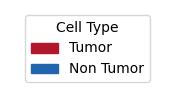

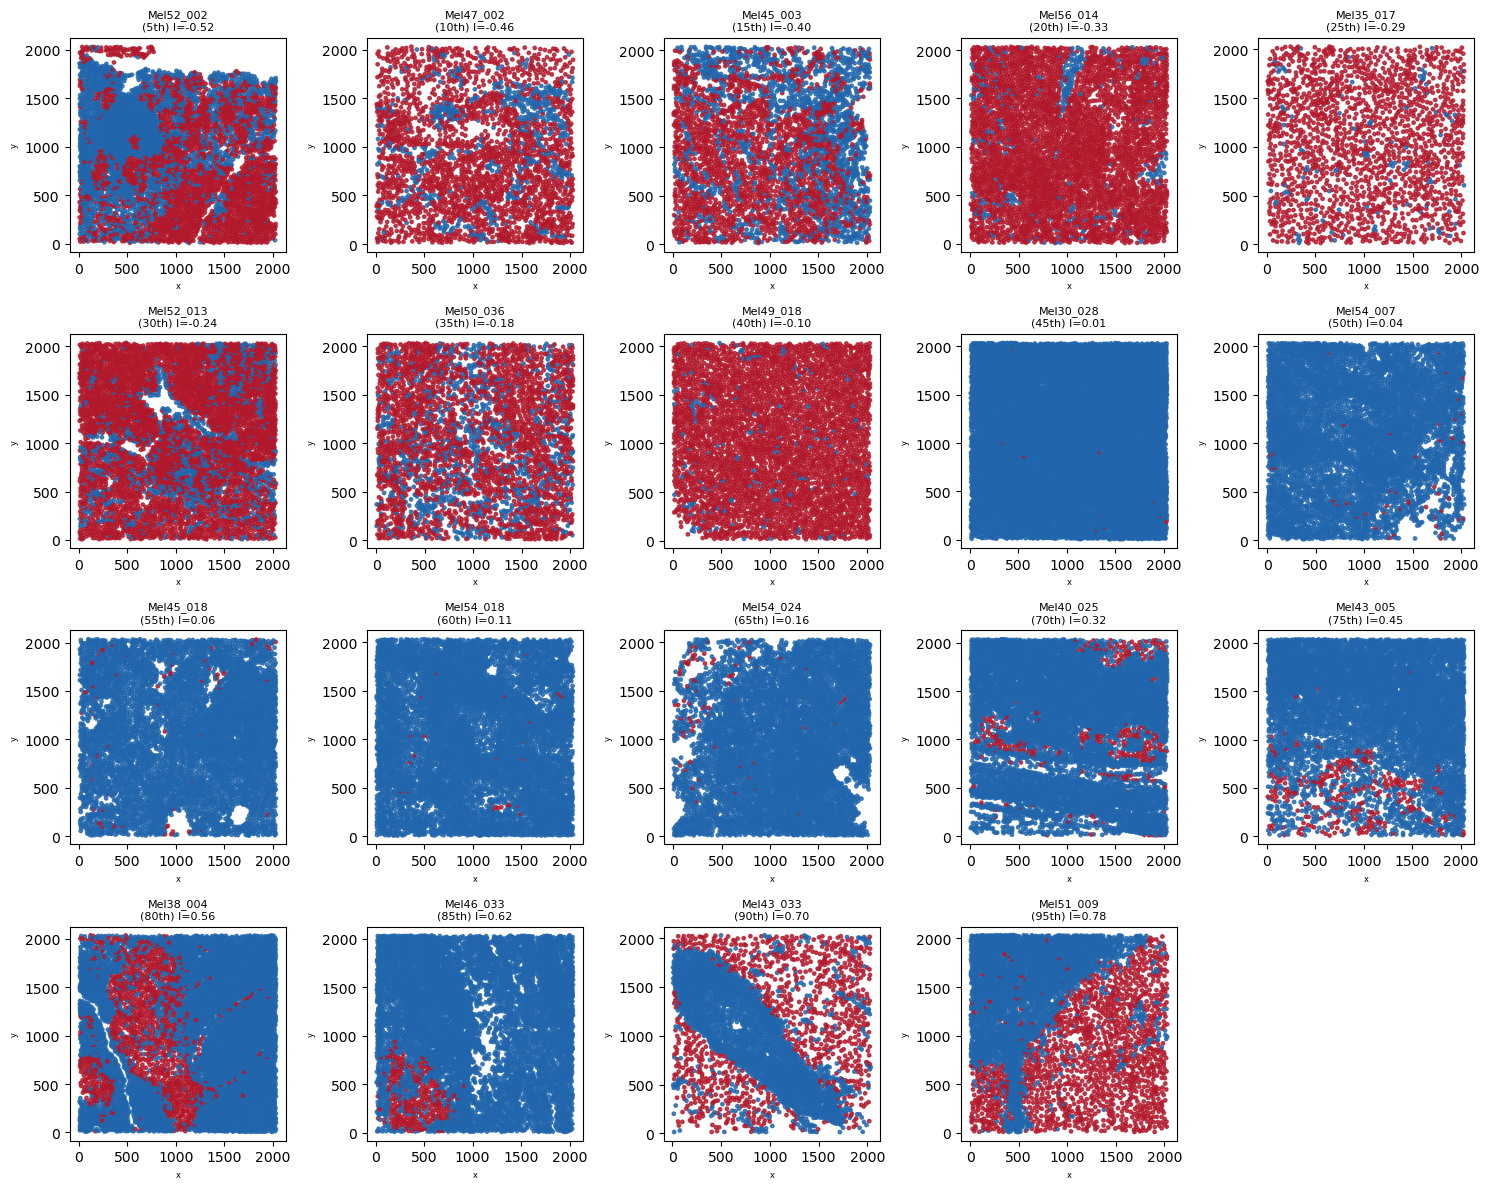

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- determine percentile images ---
percentiles = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
cutoffs = np.percentile(plot_df["moran_I"], percentiles)

# find the imageIDs closest to those percentiles
selected_imgs = []
for p, c in zip(percentiles, cutoffs):
    img_id = plot_df.iloc[(plot_df["moran_I"] - c).abs().argsort().iloc[0]]["imageID"]
    selected_imgs.append((p, img_id))

print("Selected images by percentile:")
for p, img in selected_imgs:
    print(f"{p}th percentile -> {img}")

# --- prepare color map and legend ---
color_map = {"Tumor": "#b2182b", "Non Tumor": "#2166ac"}  # crimson / dark blue
handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

fig_legend = plt.figure(figsize=(2, 1))
fig_legend.legend(handles=handles, title="Cell Type", loc="center")
plt.axis("off")
plt.show()

cols = 5
rows = len(selected_imgs) // cols + int(len(selected_imgs) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axs = axs.flatten()  # make iterable

# --- plot each image into a subplot ---
for ax, (p, img) in zip(axs, selected_imgs):
    g = df[df["imageID"] == img].copy()
    colors = g["cell_type"].map(color_map)
    ax.scatter(g["x"], g["y"], c=colors, s=6, alpha=0.8)
    moran_val = plot_df.loc[plot_df["imageID"] == img, "moran_I"].values[0]
    ax.set_title(f"{img}\n({p}th) I={moran_val:.2f}", fontsize=8)
    ax.set_xlabel("x", fontsize=6)
    ax.set_ylabel("y", fontsize=6)
    ax.axis("equal")

# hide any unused axes
for ax in axs[len(selected_imgs):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Plot ranked ROI (Interface only)

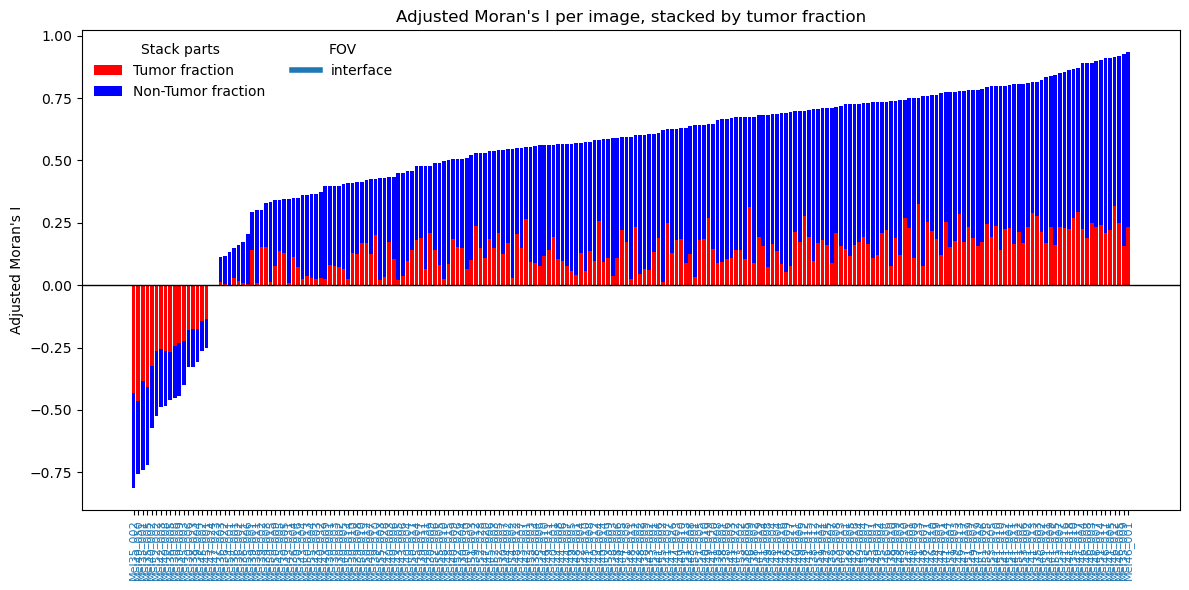

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- build tumor_frac and fov maps ---
_tmp = raw_df.dropna(subset=["imageID", "cell_type", "fov"]).copy()
_tmp["tumor_bin"] = (_tmp["cell_type"].values == "Tumor Cell").astype(float)

tumor_frac = _tmp.groupby("imageID")["tumor_bin"].mean()
fov_map    = _tmp.groupby("imageID")["fov"].first()

# attach to adj_df
plot_df = adj_df.copy()
plot_df["tumor_frac"] = plot_df["imageID"].map(tumor_frac)
plot_df["fov"]        = plot_df["imageID"].map(fov_map)

plot_df = plot_df[plot_df['fov'] == 'interface']

# clean and sort
plot_df = plot_df.dropna(subset=["moran_I", "tumor_frac", "fov"]).reset_index(drop=True)
plot_df = plot_df.sort_values("moran_I", ascending=True).reset_index(drop=True)

# compute stacked heights
h_tumor = plot_df["moran_I"] * plot_df["tumor_frac"]
h_rest  = plot_df["moran_I"] * (1.0 - plot_df["tumor_frac"])
x = np.arange(len(plot_df))

# --- plot stacked bars ---
# --- plot stacked bars ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, h_tumor, color="red", label="Tumor fraction")
ax.bar(x, h_rest, bottom=h_tumor, color="blue", label="Non-Tumor fraction")
ax.axhline(0, linewidth=1, color="k")

# --- color x-axis ticks by fov ---
unique_fovs = plot_df["fov"].unique()
cmap = plt.get_cmap("tab10", len(unique_fovs))
fov_to_color = {f: cmap(i) for i, f in enumerate(unique_fovs)}

xticks = x
xticklabels = plot_df["imageID"].astype(str).tolist()
colors = [fov_to_color[f] for f in plot_df["fov"]]

ax.set_xticks(xticks, xticklabels)
for tick_label, color in zip(ax.get_xticklabels(), colors):
    tick_label.set_rotation(90)
    tick_label.set_fontsize(8)
    tick_label.set_color(color)

ax.set_ylabel("Adjusted Moran's I")
ax.set_title("Adjusted Moran's I per image, stacked by tumor fraction")
fig.tight_layout()



handles1, labels1 = ax.get_legend_handles_labels()

fov_handles = [plt.Line2D([0],[0], color=cmap(i), lw=4) for i in range(len(unique_fovs))]
fov_labels  = list(unique_fovs)
legend1 = ax.legend(handles1, labels1, title="Stack parts",
                    loc="upper left", bbox_to_anchor=(0.0, 1),
                    frameon=False)
legend2 = ax.legend(fov_handles, fov_labels, title="FOV",
                    loc="upper left", bbox_to_anchor=(0.18, 1),
                    frameon=False)
ax.add_artist(legend1)

plt.show()


Selected images by percentile:
5th percentile -> Mel45_003
10th percentile -> Mel36_001
15th percentile -> Mel30_005
20th percentile -> Mel30_003
25th percentile -> Mel47_028
30th percentile -> Mel30_009
35th percentile -> Mel52_028
40th percentile -> Mel53_003
45th percentile -> Mel52_004
50th percentile -> Mel48_011
55th percentile -> Mel49_010
60th percentile -> Mel41_003
65th percentile -> Mel47_016
70th percentile -> Mel38_007
75th percentile -> Mel35_004
80th percentile -> Mel47_021
85th percentile -> Mel47_019
90th percentile -> Mel41_002
95th percentile -> Mel41_017


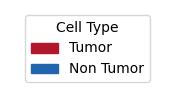

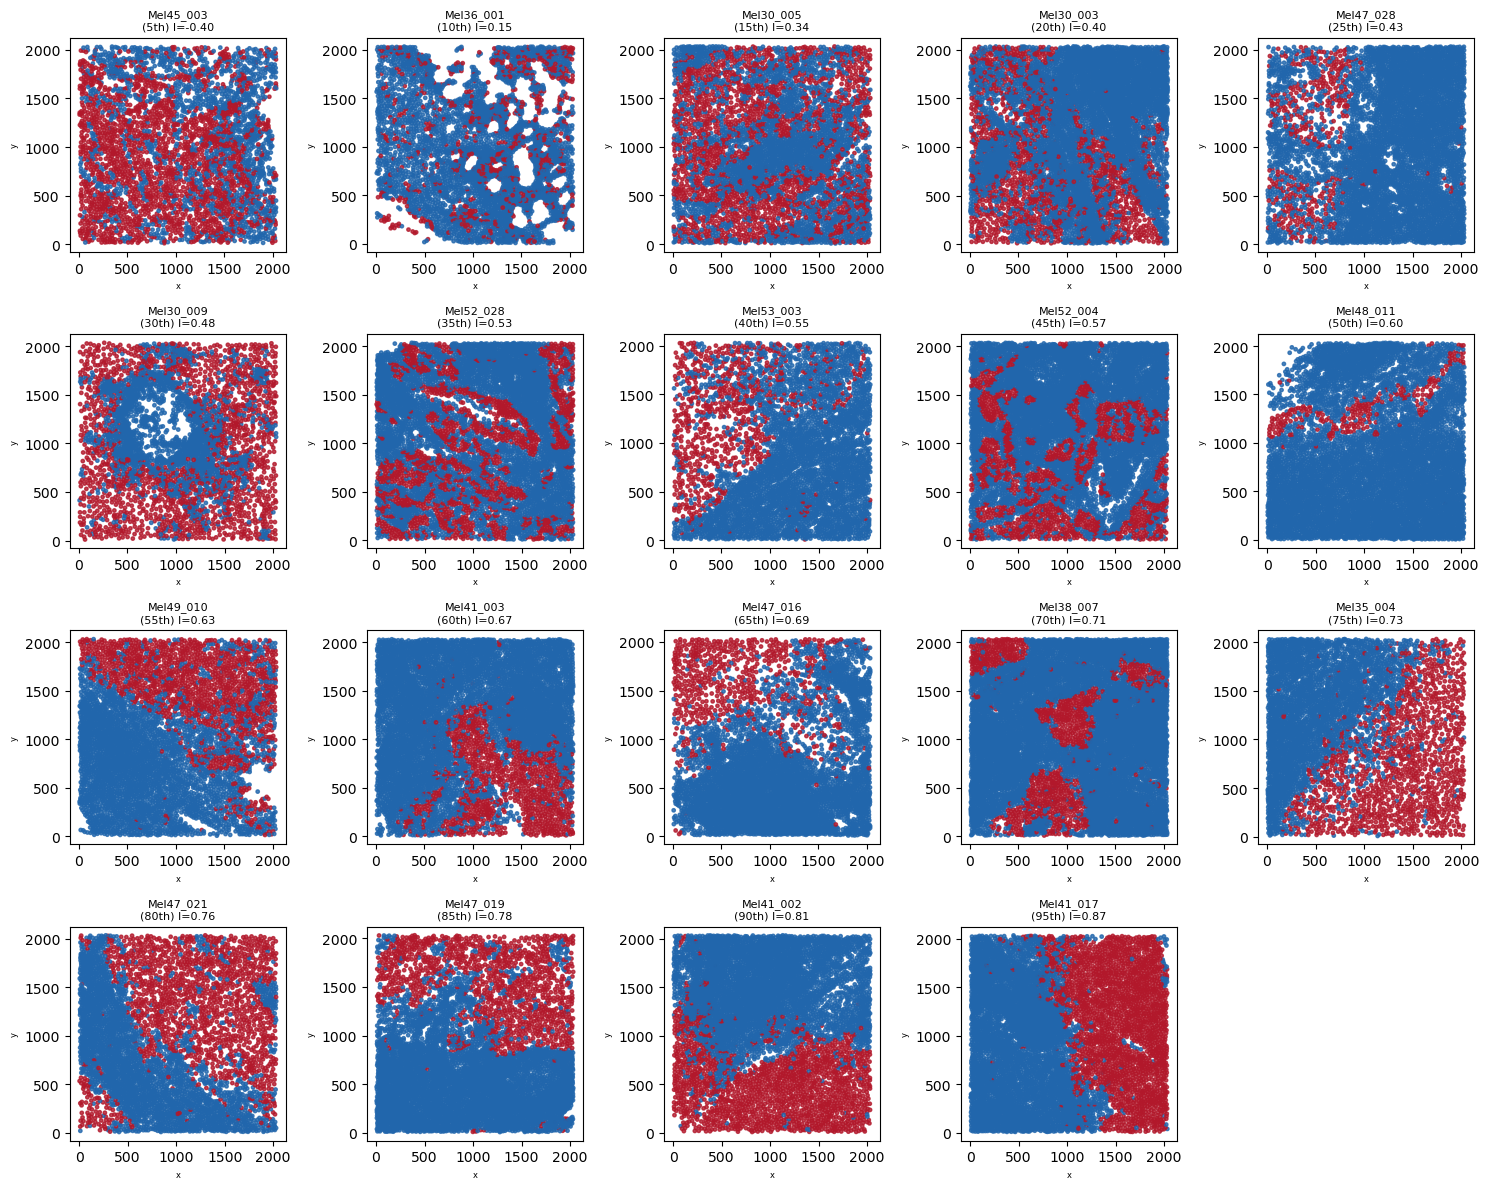

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- determine percentile images ---
percentiles = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
cutoffs = np.percentile(plot_df["moran_I"], percentiles)

# find the imageIDs closest to those percentiles
selected_imgs = []
for p, c in zip(percentiles, cutoffs):
    img_id = plot_df.iloc[(plot_df["moran_I"] - c).abs().argsort().iloc[0]]["imageID"]
    selected_imgs.append((p, img_id))

print("Selected images by percentile:")
for p, img in selected_imgs:
    print(f"{p}th percentile -> {img}")

# --- prepare color map and legend ---
color_map = {"Tumor": "#b2182b", "Non Tumor": "#2166ac"}  # crimson / dark blue
handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

fig_legend = plt.figure(figsize=(2, 1))
fig_legend.legend(handles=handles, title="Cell Type", loc="center")
plt.axis("off")
plt.show()

cols = 5
rows = len(selected_imgs) // cols + int(len(selected_imgs) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axs = axs.flatten()  # make iterable

# --- plot each image into a subplot ---
for ax, (p, img) in zip(axs, selected_imgs):
    g = df[df["imageID"] == img].copy()
    colors = g["cell_type"].map(color_map)
    ax.scatter(g["x"], g["y"], c=colors, s=6, alpha=0.8)
    moran_val = plot_df.loc[plot_df["imageID"] == img, "moran_I"].values[0]
    ax.set_title(f"{img}\n({p}th) I={moran_val:.2f}", fontsize=8)
    ax.set_xlabel("x", fontsize=6)
    ax.set_ylabel("y", fontsize=6)
    ax.axis("equal")

# hide any unused axes
for ax in axs[len(selected_imgs):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

# 3) Regression: same responder per imageID
# If responder is binary string/label, encode to 0/1. If numeric already, this will keep it.
moran_df["resp_num"] = moran_df["responder"].astype("category").cat.codes
# Linear regression: Moran’s I ~ responder (swap to logit if you want)
model = smf.ols("moran_I ~ resp_num", data=moran_df).fit()
print(model.summary())


### Calculate for XGboostPred

In [46]:
folder = '/projects/wangc/m344313/OVTMA_project/data/XGBoostPred/BMS_T1'
# read all csv files in the folder
import os
import pandas as pd

# Get list of all files in the folder
files = [f for f in os.listdir(folder) if f.endswith('.tsv')]

results = []
for file in files:
    df = pd.read_csv(os.path.join(folder, file), sep='\t')
    # get the imageID from the file name
    imageID = file.split('.')[0]
    df["XGBoostPrediction"] = np.where(df["XGBoostPrediction"].values == "Tumor Cell", "Tumor", "Non Tumor")
    df["tumor_bin"] = (df["XGBoostPrediction"] == "Tumor").astype(float)
    # calculate Moran's I
    coords = df[["Centroid_X_um","Centroid_Y_um"]].to_numpy()
    vals = df["tumor_bin"].to_numpy(dtype=float)
    I = moran_for_group(coords, vals, method=USE_METHOD, k=K, radius=RADIUS)
    results.append({"imageID": imageID,
                    "moran_I": I,
                    "responder": g["responder"].iloc[0]})
moran_df = pd.DataFrame(results).dropna(subset=["moran_I"]).reset_index(drop=True)
moran_df.to_csv('/projects/wangc/m344313/OVTMA_project/data/XGBoostPred/BMS_T1_moran_df.csv', index=False)



/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:227: RuntimeWarning: invalid value encountered in divide
  self.z /= sy
/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/people/m344313/.local/share/mamba/envs/tma22/lib/python3.10/site-packages/esda/moran.py:227: RuntimeWarnin

# For old data

In [7]:
# from the slide margin_labels_umn.pdf
label = {
    'Mel10_Reg001':'Mixed',
    'Mel10_Reg002':'Mixed',
    'Mel10_Reg003':'Unclassified',
    'Mel10_Reg004':'Mixed',
    'Mel10_Reg005':'Intact',
    'Mel10_Reg006':'Mixed',
    'Mel10_Reg007':'Mixed',
    'Mel10_Reg008':'Mixed',
    'Mel10_Reg009':'Mixed',
    'Mel10_Reg010':'Mixed',
    'Mel10_Reg021':'Mixed',
    'Mel10_Reg022':'Mixed',
    'Mel10_Reg023':'Mixed',
    'Mel10_Reg024':'Mixed',
    'Mel10_Reg025':'Mixed',
    'Mel10_Reg026':'Mixed',
    'Mel12_Reg001':'Intact',
    'Mel12_Reg002':'Intact',
    'Mel12_Reg003':'Intact',
    'Mel12_Reg004':'Intact',
    'Mel12_Reg005':'Intact',
    'Mel12_Reg006':'Unclassifed',
    'Mel12_Reg007':'Unclassifed',
    'Mel12_Reg008':'Unclassifed',
    'Mel12_Reg009':'Intact',
    'Mel12_Reg010':'Unclassifed',
    'Mel12_Reg011':'Intact',
    'Mel12_Reg012':'Intact',
    'Mel12_Reg022':'Intact',
    'Mel12_Reg023':'Intact',
    'Mel12_Reg024':'Intact',
    'Mel12_Reg025':'Intact',
    'Mel12_Reg026':'Intact',
    'Mel12_Reg033':'Intact',
    'Mel14_Reg001':'Intact',
    'Mel14_Reg002':'Intact',
    'Mel14_Reg003':'Mixed',
    'Mel14_Reg004':'Mixed',
    'Mel14_Reg005':'Mixed',
    'Mel14_Reg006':'Intact',
    'Mel14_Reg007':'Mixed',
    'Mel14_Reg008':'Mixed',
    'Mel14_Reg009':'Intact',
    'Mel14_Reg010':'Intact',
    'Mel14_Reg011':'Mixed',
    'Mel14_Reg012':'Mixed',
    'Mel14_Reg013':'Intact',
    'Mel14_Reg032':'Intact',
}
df_label = df.copy()
df_label['margin_label'] = df_label['imageID'].map(label)
# remove row if margin_label is NaN
df_label = df_label[df_label['margin_label'].notna()]


